# Test9 with Benchmarking

In [1]:
from itertools import product
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, accuracy_score
import statsmodels.api as sm
from tqdm.notebook import tqdm

from doe_modules.design import DOE, FullFactorial, CLOO, PlackettBurman, d_criterion, DOCLOO
from doe_modules.plot import bio_multicomp
from doe_modules.preferences import kwarg_savefig, outputdir
from doe_modules.simulation import Test9, MLR, AbstractSimulator, TheoreticalEffects
from doe_modules.simulation.esm9_metrics import edge_coverage, pathway_coverage, max_positive_edge_density, cai

In [2]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir
    simulator: AbstractSimulator = Test9
    run_names: list = None
    suffix: str = "_test9"

conf = Config()

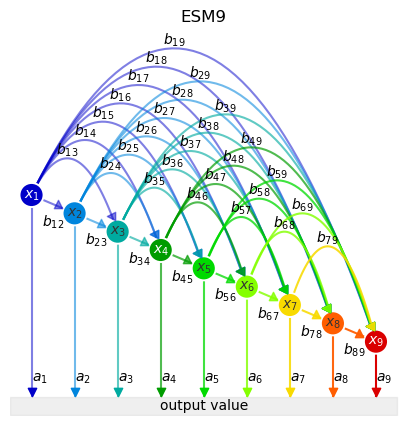

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))

esm9 = Test9(
    edge_assignsment=np.ones(45),
)

esm9.plot(ax=ax)

ax.set_title("ESM9")

if conf.savefig:
    fig.savefig(f"{conf.out}/esm9", **kwarg_savefig)

In [4]:
np.random.seed(0)
edges = np.random.randint(-1, 2, (20000, 45))

conditions = dict(
    pb=[Test9(v, model_id=i) for i, v in enumerate(edges)],
    cloo=[Test9(v, model_id=i) for i, v in enumerate(edges)],
)

designs = dict(
    pb=PlackettBurman,
    cloo=CLOO,
)

In [5]:
for k, models in tqdm(conditions.items(), total=len(designs)):
    [
        m.simulate(
            design=designs[k], n_rep=3
        ) for (i, m) in tqdm(enumerate(models), total=len(edges))
    ]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
theoretical = [
    TheoreticalEffects(
        simulation=conf.simulator(v, model_id=i), random_state=0
    ) for i, v in tqdm(enumerate(edges), total=len(edges))
]

ground_truth = [
    theoretical[i].summary(dtype=int) for i in tqdm(range(len(edges)))
]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
import warnings

warnings.simplefilter('ignore')

pb_k, cloo_k = [], []
pb_dd, cloo_dd = [], []

def kappa(res, gt):
    if gt.unique().size == 1:
        f = lambda res, gt: accuracy_score(res, gt)
    else:
        f = lambda res, gt: cohen_kappa_score(res, gt, weights="linear")
    return np.nan if res.isna().all() else f(res, gt)

# kappa = lambda res, gt: np.nan if res.isna().all() else cohen_kappa_score(res, gt, weights="linear")

for (pb, cloo, gt) in tqdm(zip(conditions["pb"], conditions["cloo"], ground_truth), total=len(edges)):
    pb_res = MLR(pb).summary(anova=True, dtype=int, fill_nan=True)
    cloo_res = MLR(cloo).summary(anova=True, dtype=int, fill_nan=True)
    pb_k += [kappa(pb_res, gt)]
    cloo_k += [kappa(cloo_res, gt)]

In [13]:
def voronoi(c_p):
    c, p = c_p
    if c < .6 and p < .6:
        ret = 0
    elif c > p:
        ret = 1
    elif c < p:
        ret = 2
    else:
        ret = 3
    return ret

def voronoi_label(c_p):
    return ["neither", "C+LOO", "PB", "both"][voronoi(c_p)]

In [313]:
dat = pd.DataFrame({
    "cloo": cloo_k,
    "pb": pb_k,
    "v": list(map(voronoi, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    "": list(map(voronoi_label, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    "edge_coverage": map(edge_coverage, edges),
    "pathway_sparsity": map(pathway_coverage, edges),
    "max_positive_edge_density": map(max_positive_edge_density, edges),
    "cai": map(cai, edges),
})

dat.to_feather(f"{outputdir}/esm_test9.feather")

In [314]:
np.save(f"{outputdir}/esm_test9_edges", edges)

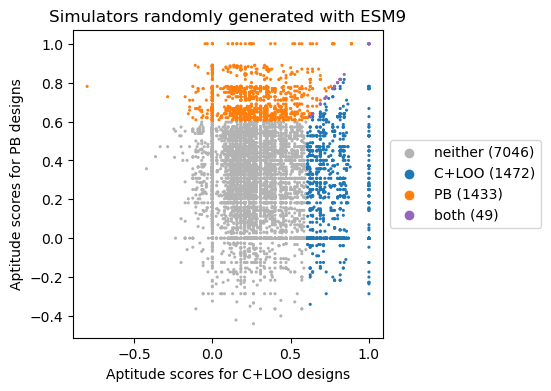

In [392]:
fig, ax = plt.subplots(figsize=(4, 4))

counts = dat.loc[:, ''].value_counts()

dat2 = pd.DataFrame({
    "cloo": dat.cloo,
    "pb": dat.pb,
    "v": dat.v,
    "": [f"{v} ({counts[v]})" for v in dat.loc[:, ""]]
})


sns.scatterplot(
    data=dat2.sort_values("v"), x="cloo", y="pb", ax=ax, hue="", palette=[".7", "C0", "C1", "C4"], s=5, linewidth=0,
)

ax.set(
    title="Simulators randomly generated with ESM9",
    xlabel="Aptitude scores for C+LOO designs", 
    ylabel="Aptitude scores for PB designs"
)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))

if conf.savefig:
    fig.savefig(f"{outputdir}/kappa_scatter_test9", **kwarg_savefig)

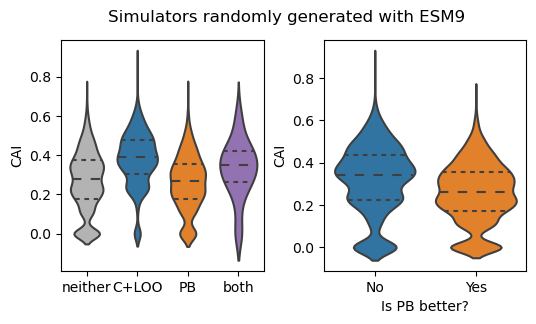

In [477]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=False)
plt.subplots_adjust(wspace=.3)

# counts = dat.loc[:, ''].value_counts()

# dat2 = pd.DataFrame({
#     "cai": dat.cai,
#     "v": dat.v,
#     "": [f"{v}\n({counts[v]})" for v in dat.loc[:, ""]]
# })


sns.violinplot(data=dat, x="", y="cai", ax=ax[0], palette=[".7", "C0", "C1", "C4"], inner="quart")

sns.violinplot(
    data=dat.assign(
        avoid_cloo=list(map(lambda boolean: ["No", "Yes"][boolean], dat.cloo < dat.pb))
    ).sort_values("avoid_cloo", ascending=True), 
    x="avoid_cloo", y="cai",
    inner="quart"
)

ax[1].set_xlabel("Is PB better?")

[a.set(ylabel="CAI") for a in ax.ravel()]

plt.suptitle("Simulators randomly generated with ESM9")

if conf.savefig:
    fig.savefig(f"{outputdir}/cai_test9", **kwarg_savefig)

In [14]:
dat = pd.DataFrame({
    "cloo": cloo_k,
    "pb": pb_k,
    "v": list(map(voronoi, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    "": list(map(voronoi_label, [[c, p] for c, p in zip(cloo_k, pb_k)])),
})

dat.to_feather(f"{conf.out}/esm{conf.suffix}.feather")

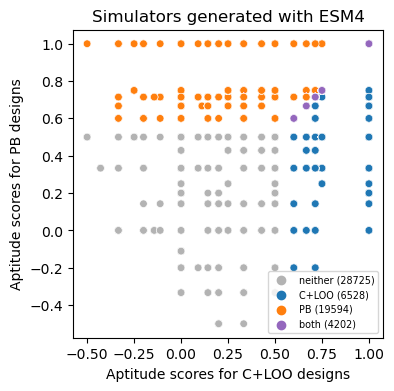

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))

counts = dat.loc[:, ''].value_counts()

dat2 = pd.DataFrame({
    "cloo": dat.cloo,
    "pb": dat.pb,
    "v": dat.v,
    "": [f"{v} ({counts[v]})" for v in dat.loc[:, ""]]

})

sns.scatterplot(
    dat2.sort_values("v"),
    x="cloo", 
    y="pb", 
    hue="",
    palette=[".7", "C0", "C1", "C4"],
    s=30, 
    # linewidth=0
)

ax.set(
    title="Simulators generated with ESM4",
    xlabel="Aptitude scores for C+LOO designs", 
    ylabel="Aptitude scores for PB designs"
)

# ax.legend(loc="center left", bbox_to_anchor=(1, .5))
ax.legend(loc="lower right", fontsize="x-small")

if conf.savefig:
    fig.savefig(f"{conf.out}/kappa_scatter{conf.suffix}", **kwarg_savefig)

In [16]:
dat

,cloo,pb,v,
0,0.000000,0.000000,0,neither
1,0.000000,0.000000,0,neither
2,0.000000,0.000000,0,neither
3,0.000000,0.000000,0,neither
4,0.000000,0.000000,0,neither
...,...,...,...,...
59044,0.750000,0.750000,3,both
59045,1.000000,0.750000,1,C+LOO
59046,0.333333,-0.333333,0,neither
59047,0.750000,0.750000,3,both
